# Final Project Template

This workbook provides the template for the final project. 

## Instructions
- Work individually or in pairs
- Each team is to complete 1 copy of this template.
  - Complete all sections.
  - Feel free to include supporting material / slides / documents as needed.
- At the end of the project, you will get 15 minutes to present this workbook to the class.

### Submission Instructions
- Submit the .ipynb with the Output cells showing the results
  - Naming convention:
  ```
      <name1>-<name2>-<project_short_name>.ipynb
  ```
- If you provide your own datasets, include the data with your .ipynb, unless it is confidential

## Section 0: Team Members
- Wendy Chan


## Section 1: Identify military vehicle from image


## Section 2: Project Definition

### Goals

The goal of this project is to identify a military vehicle image given any vehicle image.

Important:
- If this is your first project, keep the project definition as simple as possible. 
- As a rule of thumb, pick something that can be completed in 1 day. But you can always pick a more complex project (no penalty)
- If you are not sure, use the workshop problems as a reference.

### Dataset

Briefly describe the source(s) of data you are using.
- military vehicle and non-military images are scrapped from Google search image.

### Tasks

List the tasks you will perform. 

Example:
 
1. Process the image to 28x28 image and label each image with 1 or 0.  Where 1 = military vehicle and 0 = non-military vehicle
2. Shuffle and split into train and test sets
3. Train a CNN model using LeNET architecture (found from internet)
4. Compute the metrics for the algorithm.
5. Perform analysis for possible improvements.

### Data Extraction from Google search image

### - Java script
### - python script

Download image URL

Chrome -> Developer Tools -> Console

// pull down jquery into the JavaScript console
var script = document.createElement('script');
script.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.2.0/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(script);

// grab the URLs
var urls = $('.rg_di .rg_meta').map(function() { return JSON.parse($(this).text()).ou; });

// write the URls to file (one per line)
var textToSave = urls.toArray().join('\n');
var hiddenElement = document.createElement('a');
hiddenElement.href = 'data:attachment/text,' + encodeURI(textToSave);
hiddenElement.target = '_blank';
hiddenElement.download = 'urls.txt';
hiddenElement.click();

### import the necessary packages
from imutils import paths
import argparse
import requests
import cv2
import os

### construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-u", "--urls", required=True, help="path to file containing image URLs")
ap.add_argument("-o", "--output", required=True, help="path to output directory of images")
args = vars(ap.parse_args())

### grab the list of URLs from the input file, then initialize the
### total number of images downloaded thus far
rows = open(args["urls"]).read().strip().split("\n")
total = 0

### loop the URLs
for url in rows:
	try:
		# try to download the image
		r = requests.get(url, timeout=60)

		# save the image to disk
		p = os.path.sep.join([args["output"], "{}.jpg".format(
			str(total).zfill(8))])
		f = open(p, "wb")
		f.write(r.content)
		f.close()

		# update the counter
		print("[INFO] downloaded: {}".format(p))
		total += 1

	# handle if any exceptions are thrown during the download process
	except:
		print("[INFO] error downloading {}...skipping".format(p))


        # loop over the image paths we just downloaded
for imagePath in paths.list_images(args["output"]):
	# initialize if the image should be deleted or not
	delete = False
 
	# try to load the image
	try:
		image = cv2.imread(imagePath)
 
		# if the image is `None` then we could not properly load it
		# from disk, so delete it
		if image is None:
			delete = True
 
	# if OpenCV cannot load the image then the image is likely
	# corrupt so we should delete it
	except:
		print("Except")
		delete = True
 
	# check to see if the image should be deleted
	if delete:
		print("[INFO] deleting {}".format(imagePath))
		os.remove(imagePath)

		# to run the code :python download_images.py --urls urls.txt --output images/download

In [1]:
# import the necessary packages
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import imutils

import seaborn as sns
import keras
from keras import backend as K
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Using TensorFlow backend.


## Section 3: Data Engineering

Consider:
* Data Cleaning
* Data Exploration
* Imbalance / Data Sampling
* Data Encoding

In [2]:
# Set parameters

img_width = img_height = 56

train_dir_path1 = '/projectML/images/train/mveh'
train_dir_path2 = '/projectML/images/train/notmveh'

pred_dir = '/projectML/images/pred'

num_classes = 2

In [3]:
# Helper class to get list of file path

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
  
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = dirName + '/' + entry
        
        allFiles.append(fullPath)
                
    return allFiles

In [4]:
# Get the list of all files in directory tree at given path
listOfFiles1 = getListOfFiles(train_dir_path1)
listOfFiles2 = getListOfFiles(train_dir_path2)

imagefiles = listOfFiles1 + listOfFiles2

imagefiles[0]

'/projectML/images/train/mveh/00000000.jpg'

In [5]:
data = []
data_pca = []
labels = []

# loop over the input images
for imagePath in imagefiles:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath) 
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image)
    
    data.append(image) # image data for training
    data_pca.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) # to convert to gray scale for PCA

    # extract the class label from the image path and update the labels list
    label = imagePath.split('/')[-2] # find path of image
    label = 1 if label == "mveh" else 0
    labels.append(label)


In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = (np.array(data, dtype="float") - np.min(data)) / (np.max(data) - np.min(data))
data_pca = np.array(data_pca)
labels = np.array(labels)
labels.shape


(1406,)

## Section 4: Feature Engineering

Consider:
* Feature Reduction
* PCA plot in 2D

In [7]:
data.shape

(1406, 56, 56, 3)

In [8]:
# for plotting of PCA.  Else keep shape
data_PCA = data_pca.reshape(1406, 3136) # 1406 - number of samples; 3136 = 56 * 56
data_PCA.shape

(1406, 3136)

In [9]:
X = data_PCA
y = labels

Z_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_scaled)

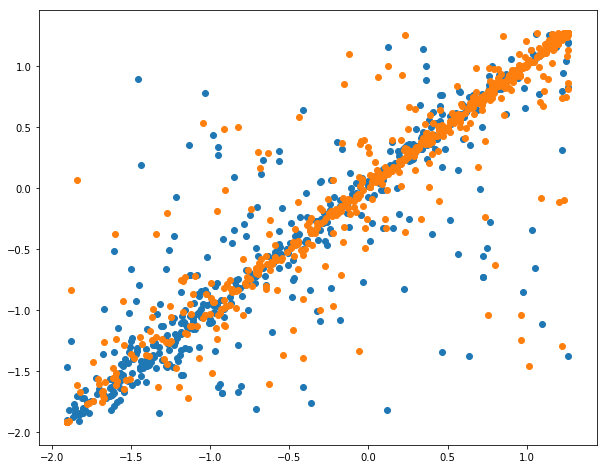

In [10]:
# plot
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(labels)):
    indices = (y == i) # all rows with label = i

    # scatter plot rows with label = i
    ax.scatter(Z_scaled[indices, 0], Z_scaled[indices, 1],
              label=labels[i])

plt.show()

### PCA shows that the 2 classes really can't be differentiated for logistic regression.   Hence, CNN is considered.

## Section 5: Model Engineering

Consider:
* Learning Curve to avoid Overfitting

In [11]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=42) # shuffle data


# convert the labels from integers to vectors
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [12]:
print(X_train.shape)
print(y_train.shape)

(1054, 56, 56, 3)
(1054, 2)


In [13]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)
    
input_shape

(56, 56, 3)

In [14]:
model = Sequential()

# filters = 32 (output depth, number of sets of filters)
# kernel_size = 3, 3 (size of the filter)
# strides = 1, 1 (how much to slide the window)
# padding = 'valid' (no padding). ('same' = padding)
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsampling

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10240128  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

In [15]:
from keras.optimizers import Adam
# losses: https://keras.io/losses/
# multi-class classification - categorical_crossentropy
# binary classification - binary_crossentropy
# regression - mean_squared_error

# optimisers: https://keras.io/optimizers/
# SGD - simple (good for fine tuning with lr=very small)
# RMSProp - apparently good for RNNs
# Adam - more black box but popular!
# Adagrad - smaller updates for more frequently updated weights

# sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Tensorboard for learning curve
# Early stopping (to avoid overfitting)
# Model checkpoint (to save model periodically)

tensorboard = TensorBoard(log_dir='./logs/mnist_cnn')

# stop training early if val_loss increases for 2 consecutive epochs
# this way we don't train forever and overfit
earlystop = EarlyStopping(patience=5)

checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')

In [17]:
model.fit(X_train, y_train, batch_size=128, epochs=20,
          verbose=1, callbacks=[tensorboard, 
                                earlystop, 
                                checkpoint],
          validation_split=0.25) # set aside 25% for validation

Train on 790 samples, validate on 264 samples
Epoch 1/20
790/790 [==============================] - 32s 40ms/step - loss: 1.5917 - acc: 0.4975 - val_loss: 0.7240 - val_acc: 0.5530
Epoch 2/20
790/790 [==============================] - 31s 40ms/step - loss: 0.6982 - acc: 0.5329 - val_loss: 0.6484 - val_acc: 0.6477
Epoch 3/20
790/790 [==============================] - 31s 40ms/step - loss: 0.6531 - acc: 0.6228 - val_loss: 0.5998 - val_acc: 0.8030
Epoch 4/20
790/790 [==============================] - 35s 45ms/step - loss: 0.6030 - acc: 0.7089 - val_loss: 0.6997 - val_acc: 0.5265
Epoch 5/20
790/790 [==============================] - 37s 47ms/step - loss: 0.5763 - acc: 0.6785 - val_loss: 0.5040 - val_acc: 0.8295
Epoch 6/20
790/790 [==============================] - 37s 47ms/step - loss: 0.5042 - acc: 0.7519 - val_loss: 0.4602 - val_acc: 0.8030
Epoch 7/20
790/790 [==============================] - 39s 49ms/step - loss: 0.4566 - acc: 0.7772 - val_loss: 0.3945 - val_acc: 0.8561
Epoch 8/20
790/7

## Section 6: Evaluate Metrics

Consider:
* Which metric to use?

In [18]:
pred = model.predict_classes(X_test)
pred

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,

In [20]:
print("pred shape:", pred.shape)
print("y_test shape:", y_test.shape)

pred shape: (352,)
y_test shape: (352, 2)


In [22]:
# check accuracy

print(accuracy_score(y_test.argmax(axis=1), pred))

# number of incorrect ones
print((np.argmax(y_test, axis=1) != pred).sum())

0.7897727272727273
74


              precision    recall  f1-score   support

           0       0.77      0.84      0.81       182
           1       0.81      0.74      0.77       170

   micro avg       0.79      0.79      0.79       352
   macro avg       0.79      0.79      0.79       352
weighted avg       0.79      0.79      0.79       352



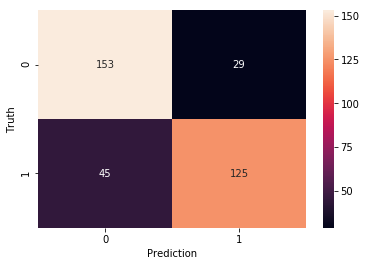

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
#print(confusion_matrix(y_test.argmax(axis=1), pred))

ax = sns.heatmap(confusion_matrix(y_test.argmax(axis=1), pred), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

print(classification_report(y_test.argmax(axis=1), pred))

actual 1 predicted 0


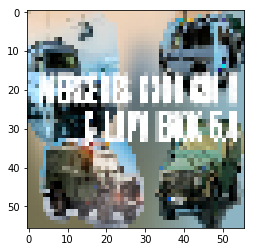

In [24]:
truth = y_test.argmax(axis=1)

index = 10

print('actual', truth[index], 'predicted', pred[index])
plt.imshow(X_test[index])

### See images of wrongly classified vehicles

In [25]:
i = 0
wrong_index = []

while i < truth.shape[0]:
    
    # not military but predict as military
    #wrong_data = pred[i] - truth[i]
    
    # military but predict as not military
    wrong_data = truth[i] - pred[i]
    if wrong_data == 1:
        wrong_index.append(i)
    i = i + 1


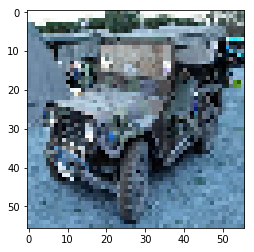

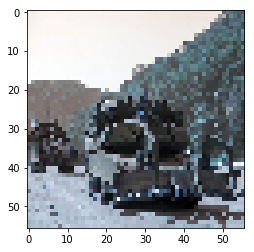

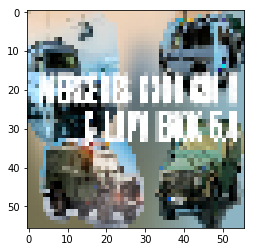

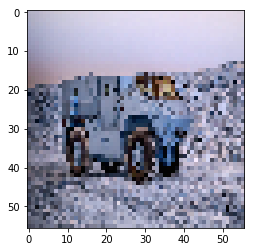

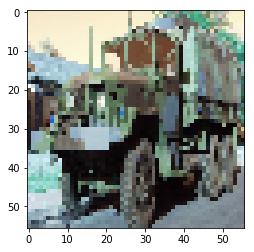

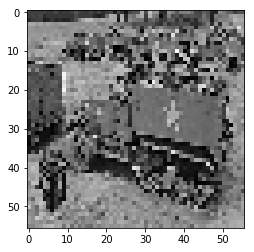

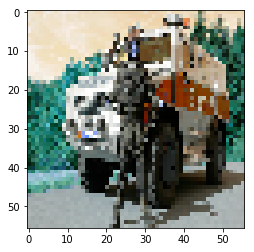

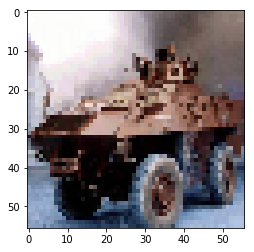

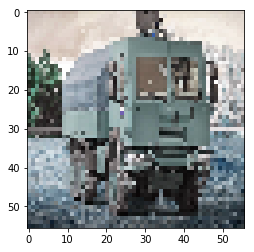

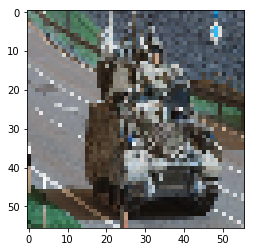

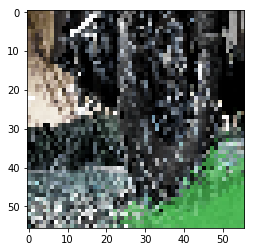

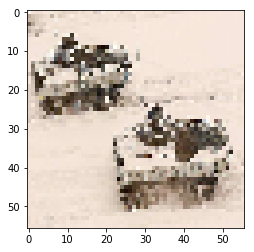

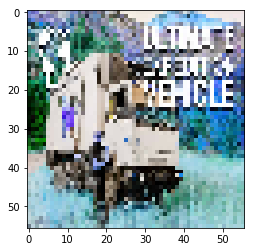

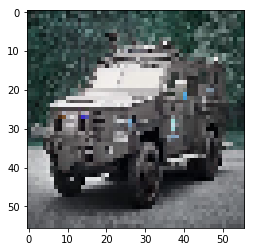

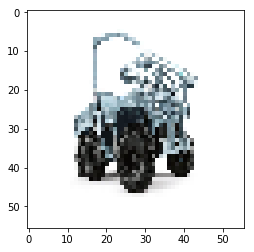

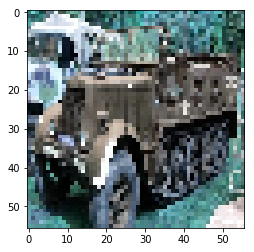

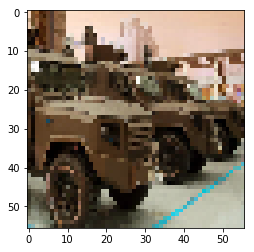

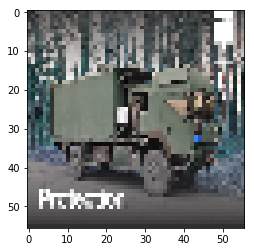

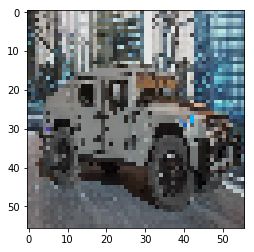

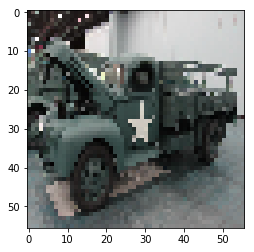

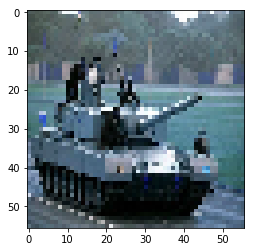

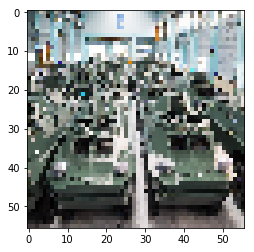

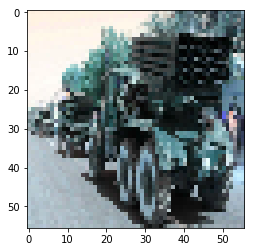

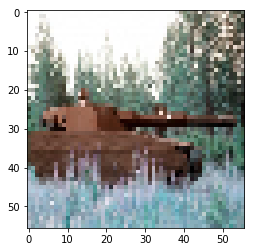

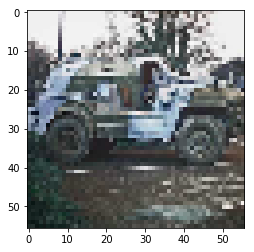

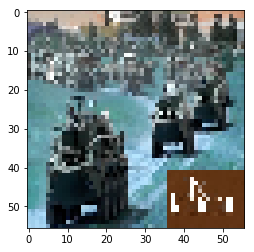

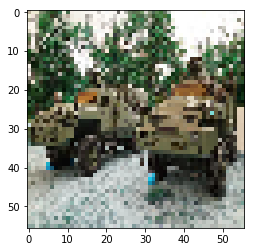

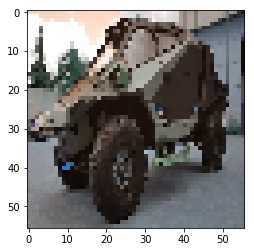

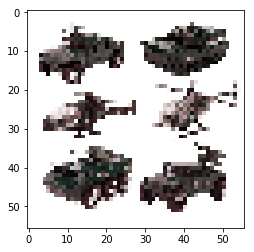

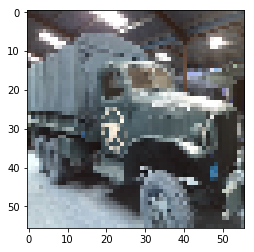

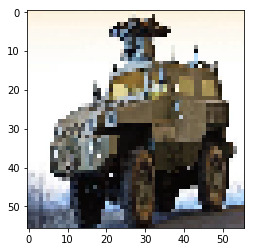

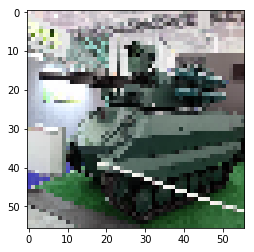

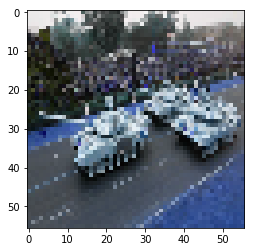

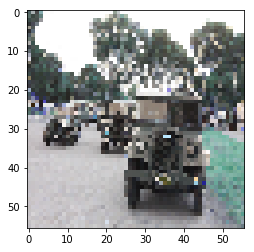

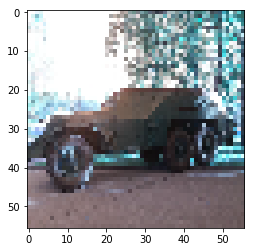

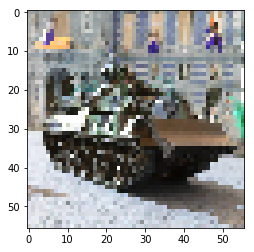

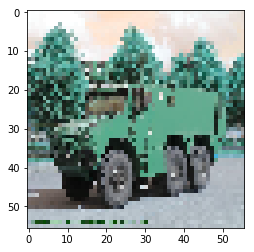

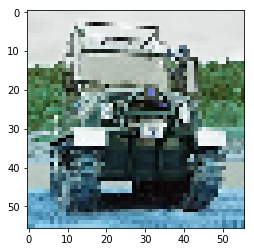

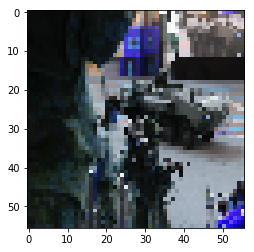

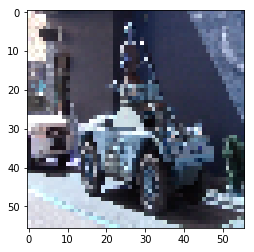

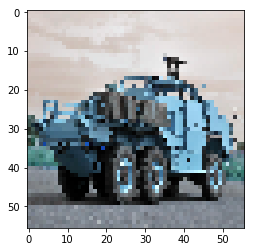

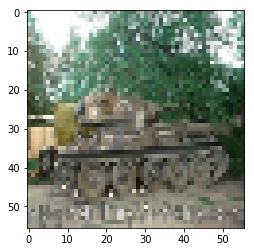

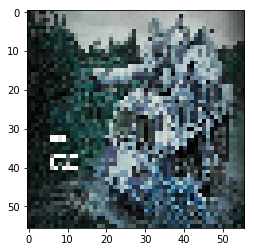

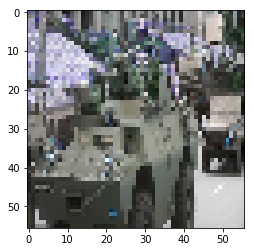

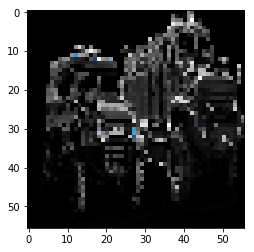

In [26]:
for i in wrong_index:
    plt.imshow(X_test[i])
    plt.show()

### Predict picture

In [53]:
Predimagefiles = getListOfFiles(pred_dir)

In [54]:
pred_data = []
orig_data = []

# loop over the input images
for imagePath in Predimagefiles:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    orig = image.copy()
    #cv2.imshow('image',image)
    
    image = cv2.resize(image, (img_height, img_width))
    image = img_to_array(image)
        
    pred_data.append(image)
    orig_data.append(orig)

In [55]:
pred_data = np.array(pred_data)
pred_data.shape

(1, 56, 56, 3)

In [56]:
pred1 = model.predict(pred_data)
pred1[0]


array([1., 0.], dtype=float32)

In [57]:
# Input index to view picture
pred_data_index = 0

(notmveh, mveh) = model.predict(pred_data)[pred_data_index]


# build the label
label = "Military Vehicle" if mveh > notmveh else "Not Military Vehicle"
proba = mveh if mveh > notmveh else notmveh
label = "{}: {:.2f}%".format(label, proba * 100)
 
# draw the label on the image
output = imutils.resize(orig_data[pred_data_index], width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
 
# show the output image
cv2.imshow("Output", output)
cv2.waitKey(0)

-1

## Section 7: Observations and analysis

Answer the following questions:
1. What do you conclude from the metrics?

3. What improvements do you propose?

Observation
------------------
Result shows that cars that are green in colour are recognised as military vehicles.
Added about 100 green car images (non-military vehicles) for training.

This gives better result and most green car can now be predicted as non-military vehicle.
Tried changing the models:
 - first model (accuracy : 75%)
     model.add(Conv2D(32, kernel_size=(3, 3), activation='relu, input_shape=input_shape))
     model.add(Conv2D(64, (3, 3), activation='relu'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu'))
     model.add(Dense(num_classes, activation='softmax'))

  - Added more images of green car (accuracy : 76%)
  
  - Added one more Conv2D layer (accuracy : 79%)
  
  - Change activation to "sigmoid" and binary_crossentropy (accuracy : 76%)

However, the model is only able to recognise vehicle.  When given an image of non-vehicle (e.g. dog), it predicted that it is a military vehicle

Improvements
---------------------

- to try boosting or
- add pre-step to train model to identify vehicles vs non-vehicles.  Then apply this model to identify between military and non-military vehicles
